In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import numpy as np
import csv
from tqdm import tqdm

"""Change to the data folder"""
new_path = "./new_train/new_train/"

# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [6]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
val_dataset  = ArgoverseDataset(data_path=new_path)

### Create a loader to enable batch processing

In [7]:
batch_sz = 100

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    city = [scene['city'] for scene in batch]
    scene_idx = [scene['scene_idx'] for scene in batch]
    agent_id = [scene['agent_id'] for scene in batch]
    car_mask = [scene['car_mask'] for scene in batch]
    track_id = [scene['track_id'] for scene in batch]
    pin = [scene['p_in'] for scene in batch]
    vin = [scene['v_in'] for scene in batch]
    pout = [scene['p_out'] for scene in batch]
    vout = [scene['v_out'] for scene in batch]
    lane = [scene['lane'] for scene in batch]
    lane_norm = [scene['lane_norm'] for scene in batch]
    
    
    return [city, scene_idx, agent_id, car_mask, track_id, pin, vin, pout, vout, lane, lane_norm]

val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)

### Visualize the batch of sequences

In [8]:
import matplotlib.pyplot as plt
import random

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

In [4]:
# # def show_sample_batch()
# x_file = open('x_coords.txt', 'a') 
# y_file = open('y_coords.txt', 'a')
    
with open('x_vals_in', 'w') as csv_x_in:
    with open('y_vals_in', 'w') as csv_y_in:
        with open('x_vals_out', 'w') as csv_x_out:
            with open('y_vals_out', 'w') as csv_y_out:
                with open('v_mag_all', 'w') as v_mag_all:
                    with open('v_mag_age', 'w') as v_mag_age:

                        # using csv.writer method from CSV package
                        write_x_in = csv.writer(csv_x_in)
                        write_y_in = csv.writer(csv_y_in)
                        write_x_out = csv.writer(csv_x_out)
                        write_y_out = csv.writer(csv_y_out)
                        write_v_all = csv.writer(v_mag_all)
                        write_v_age = csv.writer(v_mag_age)

                        for i_batch, sample_batch in tqdm(enumerate(val_loader)):
                            
                            if i_batch >= 20000:
                                break
                                
                            city, scene_idx, agent_id, car_mask, track_id, pin, vin, pout, vout, lane, lane_norm = sample_batch
                            pin = np.array(pin)
                            pout = np.array(pout)
                            vin = np.array(vin)
                            vout = np.array(vout)
                            car_mask = np.array(car_mask)
                            
                            for i in range(len(agent_id)):
                                agent_index = np.where(track_id[i] == agent_id[i])[0][0]
                                mask = car_mask[i].reshape([-1]).astype(int)
        
                                pin_x = pin[i, mask, :, 0].flatten()
                                pin_y = pin[i, mask, :, 1].flatten()

                                pout_x = pout[i, mask, :, 0].flatten()
                                pout_y = pout[i, mask, :, 1].flatten()
                                
                                vin_x = vin[i, agent_index, :, 0]
                                vin_y = vin[i, agent_index, :, 1]
                                vin_mag = (vin_x**2 + vin_y**2) ** (1/2)
                                
                                vout_x = vout[i, agent_index, :, 0]
                                vout_y = vout[i, agent_index, :, 1]
                                vout_mag = (vout_x**2 + vout_y**2) ** (1/2)
                                v_agent_mag = np.append(vin_mag, vout_mag)
                                
                                
                                vin_all_x = vin[i, mask, :, 0]
                                vin_all_y = vin[i, mask, :, 1]
                                vin_all_mag = (vin_all_x**2 + vin_all_y**2) ** (1/2)
                                vout_all_x = vout[i, mask, :, 0]
                                vout_all_y = vout[i, mask, :, 1]
                                vout_all_mag = (vout_all_x**2 + vout_all_y**2) ** (1/2)
                                v_all_mag = np.append(vin_all_mag, vout_all_mag)
                                
                                write_x_in.writerow(pin_x)
                                write_y_in.writerow(pin_y)

                                write_x_out.writerow(pout_x)
                                write_y_out.writerow(pout_y)
                                
                                write_v_age.writerow(v_agent_mag)
                                write_v_all.writerow(v_all_mag)

20000it [21:07, 15.77it/s]


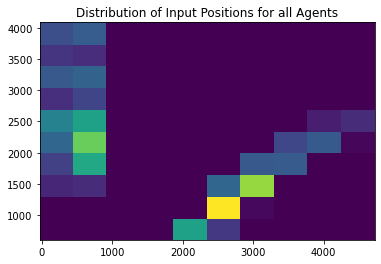

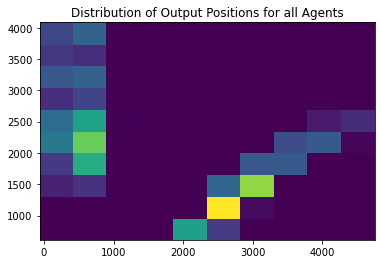

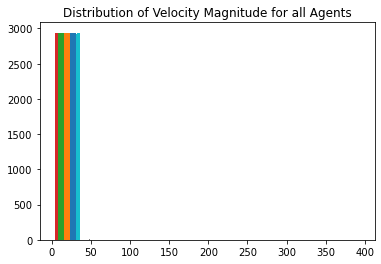

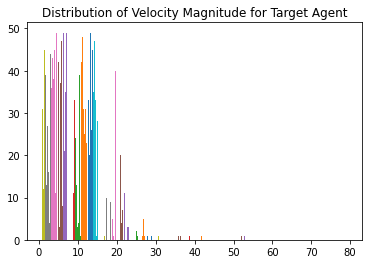

In [6]:
import matplotlib.pyplot as plt
import random

def show_input_positions():
    x_in = np.loadtxt('x_vals_in', unpack=True, delimiter=',').flatten()
    y_in = np.loadtxt('y_vals_in', unpack=True, delimiter=',').flatten()

    plt.hist2d(x_in, y_in)
    plt.title("Distribution of Input Positions for all Agents")
    plt.show()
    plt.close()

show_input_positions()
    
def show_output_positions():
    x_out = np.loadtxt('x_vals_out', unpack=True, delimiter=',').flatten()
    y_out = np.loadtxt('y_vals_out', unpack=True, delimiter=',').flatten()

    plt.hist2d(x_out,y_out)
    plt.title("Distribution of Output Positions for all Agents")
    plt.show()
    plt.close()
    
show_output_positions()

def show_velocity_all():
    v_mag_all = np.loadtxt('v_mag_all', unpack=True, delimiter=',')

    plt.hist(v_mag_all)
    plt.title("Distribution of Velocity Magnitude for all Agents")
    plt.show()
    plt.close()

show_velocity_all()
    
def show_velocity_agent():
    v_mag_age = np.loadtxt('v_mag_age', unpack=True, delimiter=',')

    plt.hist(v_mag_age)
    plt.title("Distribution of Velocity Magnitude for Target Agent")
    plt.show()
    plt.close()

show_velocity_agent()

In [9]:
pinxy = np.zeros((10, 10))
poutxy = np.zeros((10, 10))

vin_all = {}
vin_age = {}

In [11]:
for i_batch, sample_batch in tqdm(enumerate(val_loader)):

    city, scene_idx, agent_id, car_mask, track_id, pin, vin, pout, vout, lane, lane_norm = sample_batch
    pin = np.array(pin)
    pout = np.array(pout)
    vin = np.array(vin)
    vout = np.array(vout)
    car_mask = np.array(car_mask)

    for i in range(10):
        vin_all[i] = 0
        vin_age[i] = 0
        
    
    for i in range(len(agent_id)):
        agent_index = np.where(track_id[i] == agent_id[i])[0][0]
        mask = car_mask[i].reshape([-1]).astype(int)

#         pin_x = (pin[i, mask, :, 0].flatten() / 500).astype(np.int32)
#         pin_y = (pin[i, mask, :, 1].flatten() / 500).astype(np.int32)
        
#         pout_x = (pout[i, mask, :, 0].flatten() / 400).astype(np.int32)
#         pout_y = (pout[i, mask, :, 1].flatten() / 400).astype(np.int32)
        
#         x = int(np.average(pin_x))
#         y = int(np.average(pin_y))
#         if x < 10 and y < 10:
#             pinxy[x, y] += 1
            
#         x = int(np.average(pout_x))
#         y = int(np.average(pout_y))
#         if x < 10 and y < 10:
#             poutxy[x, y] += 1
            

        vin_x = vin[i, agent_index, :, 0]
        vin_y = vin[i, agent_index, :, 1]
        vin_mag = (vin_x**2 + vin_y**2) ** (1/2)

        vout_x = vout[i, agent_index, :, 0]
        vout_y = vout[i, agent_index, :, 1]
        vout_mag = (vout_x**2 + vout_y**2) ** (1/2)
        v_agent_mag = np.append(vin_mag, vout_mag)
        
        v_agent_mag = (v_agent_mag.flatten() / 4).astype(np.int32)

        vin_age[0] += np.count_nonzero(v_agent_mag == 0)
        vin_age[1] += np.count_nonzero(v_agent_mag == 1)
        vin_age[2] += np.count_nonzero(v_agent_mag == 2)
        vin_age[3] += np.count_nonzero(v_agent_mag == 3)
        vin_age[4] += np.count_nonzero(v_agent_mag == 4)
        vin_age[5] += np.count_nonzero(v_agent_mag == 5)
        vin_age[6] += np.count_nonzero(v_agent_mag == 6)
        vin_age[7] += np.count_nonzero(v_agent_mag == 7)
        vin_age[8] += np.count_nonzero(v_agent_mag == 8)
        vin_age[9] += np.count_nonzero(v_agent_mag == 9)

        vin_all_x = vin[i, mask, :, 0]
        vin_all_y = vin[i, mask, :, 1]
        vin_all_mag = (vin_all_x**2 + vin_all_y**2) ** (1/2)
        vout_all_x = vout[i, mask, :, 0]
        vout_all_y = vout[i, mask, :, 1]
        vout_all_mag = (vout_all_x**2 + vout_all_y**2) ** (1/2)
        v_all_mag = np.append(vin_all_mag, vout_all_mag)
        
        v_all_mag = (v_all_mag.flatten() / 4).astype(np.int32)

        vin_all[0] += np.count_nonzero(v_all_mag == 0)
        vin_all[1] += np.count_nonzero(v_all_mag == 1)
        vin_all[2] += np.count_nonzero(v_all_mag == 2)
        vin_all[3] += np.count_nonzero(v_all_mag == 3)
        vin_all[4] += np.count_nonzero(v_all_mag == 4)
        vin_all[5] += np.count_nonzero(v_all_mag == 5)
        vin_all[6] += np.count_nonzero(v_all_mag == 6)
        vin_all[7] += np.count_nonzero(v_all_mag == 7)
        vin_all[8] += np.count_nonzero(v_all_mag == 8)
        vin_all[9] += np.count_nonzero(v_all_mag == 9)

2060it [07:57,  4.32it/s]


TypeError: '<' not supported between instances of 'dict' and 'float'

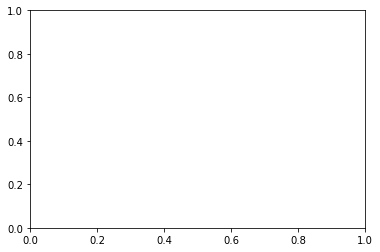

In [51]:
print(vin_age)

{0: 637, 1: 366, 2: 545, 3: 308, 4: 61, 5: 58, 6: 57, 7: 17, 8: 6, 9: 2}


In [52]:
print(vin_all)

{0: 40106, 1: 19992, 2: 43483, 3: 12002, 4: 3127, 5: 2701, 6: 1575, 7: 323, 8: 114, 9: 38}


(array([[10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 9.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 7.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 7.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.],
        [ 8.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 8.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 8.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([    0. ,  3850.8,  7701.6, 11552.4, 15403.2, 19254. , 23104.8,
        26955.6, 30806.4, 34657.2, 38508. ]),
 <a list of 10 Lists of Patches objects>)

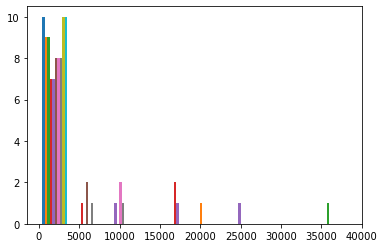

In [49]:
# pinx_list = []
# piny_list = []
# for x in range(pinxy.shape[0]):
#     for y in range(pinxy.shape[1]):
        
plt.hist(pinxy)

In [18]:
vin_age_list = []
vin_all_list = []

In [19]:
for key, value in vin_age.items():
     while value > 0:
            vin_age_list.append(key * 4)
            value -= 1
for key, value in vin_all.items():
     while value > 0:
            vin_all_list.append(key * 4)
            value -= 1

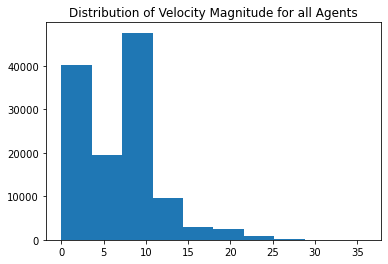

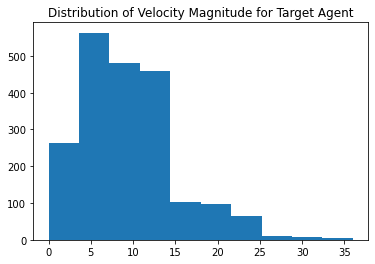

In [22]:
plt.hist(vin_all_list)
plt.title("Distribution of Velocity Magnitude for all Agents")
plt.show()
plt.close()

plt.hist(vin_age_list)
plt.title("Distribution of Velocity Magnitude for Target Agent")
plt.show()
plt.close()


In [ ]:
vin_all_list = []

In [ ]:
for key, value in vin_all.items():
     while value > 0:
            vin_all_list.append(key * 4)